In [1]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from corextopic import corextopic as ct
import corextopic.vis_topic as vt
import os
from nltk.tokenize import TweetTokenizer, word_tokenize
import re
from nltk.corpus import words, PlaintextCorpusReader
from collections import defaultdict
import math
import matplotlib.pyplot as plt

In [2]:
parent_path = '/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis'

social_media_data_folder_paths = [
    f'{parent_path}/Data/Hardwarezone Data/Cleaned Data', 
    f'{parent_path}/Data/Twitter Data/Cleaned Data/Policies/Combined',
    f'{parent_path}/Data/Facebook Data/Cleaned Data/Policies/Combined',
    f'{parent_path}/Data/Instagram Data/Cleaned Data/Policies/Combined',
    f'{parent_path}/Data/Reddit Data/Cleaned Data/Policies/Combined',
]

In [3]:
def get_policy_data(policy, folders):
    frames = []
    for folder in folders:
        files = [file for file in os.listdir(folder) if file.endswith('.csv')]
        for file in files:
            if policy.lower() in file.lower():
                df = pd.read_csv(f'{folder}/{file}')
                df = df[['Comments', 'Comment Datetime', 'actionable', 'valuable']]
                frames.append(df)
                print(True)
                break
    final_df = pd.concat(frames, ignore_index=True)
    return final_df

def remove_hashtag_mentions_urls(text):
    # e.sub(r"(?:\@|https?\://)\S+", "", text) # remove mentions and url only
    return re.sub(r"(?:\@|\#|https?\://)\S+", "", text)


noun_tags = ['NN', 'NNS', 'NNP', 'NNPS'] # POS tags for nouns

def topic_doc_unigram(doc_words: list, k: int = 1) -> (defaultdict, list):
    """
    Creating unigram model for all the nouns in the policy topic text document.  

    Args:
        doc_words (list): list of tokenized words in the text document
        k (int): smoothing pseudo-count for each unigram

    Returns:
        [defaultdict]: unigram model with every unigram as key and its probabilty as value
        [list]: list of nouns in the document
    """
    doc_tags = nltk.pos_tag(doc_words)
    doc_nouns_tag = [tag[0].lower() for tag in doc_tags if tag[1] in noun_tags]
    doc_nouns = [w for w in doc_nouns_tag if re.search('^[a-z]+$', w)]

    num_words = len(doc_nouns)

    nouns_count = defaultdict(int)
    for word in doc_nouns:
        nouns_count[word] += 1
    nouns_count['[UNK]'] = 0
    
    vocab_size = len(nouns_count)

    doc_unigram = defaultdict(int)
    for key, v in nouns_count.items():
        doc_unigram[key] = (v + k) / (num_words + k*vocab_size)
    
    return doc_unigram, doc_nouns


def comment_unigram(comment: str, k: int = 1) -> (defaultdict, list):
    """
    Creating unigram model for all the nouns in an user's comment.

    Args:
        doc_words (list): list of tokenized words in the comment
        k (int): smoothing pseudo-count for each unigram

    Returns:
        [defaultdict]: unigram model with every unigram as key and its probabilty as value
        [list]: list of nouns in the comment
    """
    comment_words = word_tokenize(comment)
    comment_tags = nltk.pos_tag(comment_words)
    comment_nouns_tag = [tag[0].lower() for tag in comment_tags if tag[1] in noun_tags]
    comment_nouns = [w for w in comment_nouns_tag if re.search('^[a-z]+$', w)]

    num_words = len(comment_nouns)

    cmt_nouns_count = defaultdict(int)
    for word in comment_nouns:
        cmt_nouns_count[word] += 1
    cmt_nouns_count['[UNK]'] = 0
    
    vocab_size = len(cmt_nouns_count)

    cmt_unigram = defaultdict(int)
    for key, v in cmt_nouns_count.items():
        cmt_unigram[key] = (v + k) / (num_words + k*vocab_size)
    
    return cmt_unigram, comment_nouns

def KLDiv_relevance_score(doc_unigram: dict, comment_unigram: dict, doc_nouns: list, comment_nouns: list) -> int:
    """
    Calculate the KL-divergence relevance score between targetted document unigram model and comment unigram model. Feature 5 for thoughtful model (Relevance feature). 

    Args:
        doc_unigram (dict): Targetted document unigram model with nouns only
        comment_unigram (dict): Comment unigram model with nouns only
        doc_nouns (list): list of nouns in targetted document
        comment_nouns (list): list of nouns in comment

    Returns:
        int: KL-divergence relevance score
    """
    total_vocab = set(doc_nouns).union(set(comment_nouns))

    kl_div = 0
    for word in total_vocab:
        # if comment_unigram[word] * doc_unigram[word] != 0:
        if word not in doc_unigram:
            kl_div += comment_unigram[word] * math.log(comment_unigram[word] / doc_unigram['[UNK]'])
        elif word not in comment_unigram:
            kl_div += comment_unigram['[UNK]'] * math.log(comment_unigram['[UNK]'] / doc_unigram[word])
        else:
            kl_div += comment_unigram[word] * math.log(comment_unigram[word] / doc_unigram[word])

    return kl_div

# Circuit Breaker

In [4]:
cb_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/circuit breaker_valuable_opinions.csv', index_col=0)
cb_df.drop(columns=['index'], inplace=True)
cb_df['Topic'] = 'Circuit Breaker'
len(cb_df)

4418

In [5]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
circuit_breaker_comments = cb_df[cb_df['Topic'] == 'Circuit Breaker']
# economic_measures_comments = cb_df[cb_df['Topic'] == 'Economic Measures']
# foreign_worker_comments = cb_df[cb_df['Topic'] == 'Foreign Worker']
# mask_comments = cb_df[cb_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
# social_distancing_comments = cb_df[cb_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
# tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
# vaccination_comments = cb_df[cb_df['Topic'] == 'Vaccination']

comments = [circuit_breaker_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in cb_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

In [6]:
df_final['Relevance score'].describe()

count    4418.000000
mean       59.553376
std        87.749530
min         2.566050
25%        18.300207
50%        35.617846
75%        56.271756
max       408.447008
Name: Relevance score, dtype: float64

In [7]:
cb_df = df_final[df_final['Relevance score'] <= 20]
len(cb_df)

1161

In [8]:
eng_words = words.words()
comments = []
i = 0
for row in cb_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

cb_df['Comments'] = comments

<ipython-input-8-74ccbd2bdb25>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb_df['Comments'] = comments


In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.5)
vectorizer = vectorizer.fit(cb_df['Comments'])
tfidf = vectorizer.transform(cb_df['Comments'])
vocab = vectorizer.get_feature_names()
len(vocab)

13234

In [10]:
anchors = [
    ['panic buy', 'mask shortage', 'shortage', 'grocery', 'food', 'supplies', 'supply'], 
    ['shutdown business', 'shutdown',  'work', 'business'], 
    ['home-based learning', 'home', 'lesson', 'online', 'school'], 
    ['mental health', 'wellbeing', 'health', 'isolation'], 
    ['border close', 'travel', 'overseas'], 
    ['stay home', 'quarantine', 'lockdown', 'safe']
]
anchors = [
    [a for a in topic if a in vocab] for topic in anchors
]

model = ct.Corex(n_hidden = 20, seed = 8)
model = model.fit(tfidf, words = vocab, anchors = anchors, anchor_strength=7)
# model.get_topics(topic=0, n_words=10)

In [105]:
top_words = {}

for i, topic_ngrams in enumerate(model.get_topics()):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    top_words[f'topic{i}'] = topic_ngrams
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    print()

Topic #1: food, supply, grocery, panic buy, buy, channel, food delivery, chain, contribute, source code

Topic #2: work, business, shutdown, work home, airport, thank hard, hard work, dear minister, work protect, going work

Topic #3: home, school, stay, brent, hedge, lee kuan, kuan, great lee, mingle, brought home

Topic #4: health, isolation, mental health, scientific, fake science, does mean, hong, epidemiological, epidemiological scientific, health care

Topic #5: travel, overseas, bubble tea, bubble, tea, cent year, account base, base rate, insist going, insist

Topic #6: safe, quarantine, stay safe, hygiene, safe circuit, keeping, reminder, scary, maintain, safe distance

Topic #7: 

Topic #8: 

Topic #9: world unfortunately, unfortunately impact

Topic #10: evening lee, good evening, government open, consideration government, just consideration, evening

Topic #11: decisive protest, protest crisis, protest

Topic #12: sir fellow, kind sir, thank kind

Topic #13: 

Topic #14: pur

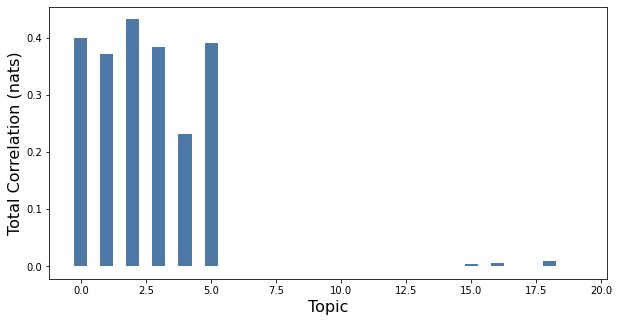

In [106]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [112]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range (20)]).astype(float)
topic_df.index = cb_df.index
df = pd.concat([cb_df, topic_df], axis=1)
df.head()

,Sentences,Comment Datetime,Textblob_polarity_score,Textblob_subjectivity_score,Vader_neg_score,Vader_neu_score,Vader_pos_score,Vader_compound_score,Emotions,Topic,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,kuma-mon wrote: Because need to handle issues ...,3/2/21,0.061806,0.607176,0.046,0.845,0.108,0.7272,fear,Circuit Breaker,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kuma-mon wrote: Because need to handle issues ...,3/2/21,-0.025833,0.550833,0.070,0.816,0.114,0.7098,sadness,Circuit Breaker,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,kuma-mon wrote: Because need to handle issues ...,3/2/21,-0.042361,0.521528,0.088,0.793,0.119,0.6133,sadness,Circuit Breaker,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,"For electricity, use lesser aircon should be o...",3/2/21,0.250000,0.500000,0.000,0.879,0.121,0.2960,anger,Circuit Breaker,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"For me, I'm lucky the company already are usin...",3/2/21,0.333333,0.833333,0.000,0.909,0.091,0.4215,anger,Circuit Breaker,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
df.to_csv('/Users/chenjianyu/Desktop/Corex Topic Modelling/cb_valuable_corex_topics.csv')

In [114]:
topics_dict = {}

for i in range(20):
    topics_dict[f'topic{i}'] = {}
    topic = df[df[f'topic_{i+1}'] == 1.0]
    pos_count = df_topic0[df_topic0['Vader_compound_score'] >= 0.1]
    neg_count = df_topic0[df_topic0['Vader_compound_score'] <= -0.01]
    emotions_count = list(df_topic0['Emotions'].value_counts())

    topics_dict[f'topic{i}']['positive'] = len(pos_count)
    topics_dict[f'topic{i}']['negative'] = len(neg_count)
    topics_dict[f'topic{i}']['emotions'] = {
        'anger': emotions_count[0],
        'fear': emotions_count[1],
        'joy': emotions_count[2],
        'neutral': emotions_count[3],
        'sadness': emotions_count[4]
        }

topics_dict['anchors'] = anchors
topics_dict['top_words'] = top_words
    
pickle.dump(topics_dict, open('cb_topic_counts.sav', 'wb'))
# x = pickle.load(open('cb_topic_counts.sav', 'rb'))

# Economic Measures

In [121]:
em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/economic measures_valuable_opinions.csv')
em_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
em_df['Topic'] = 'Economic Measures'
len(em_df)

1374

In [122]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
# circuit_breaker_comments = cb_df[cb_df['Topic'] == 'Circuit Breaker']
economic_measures_comments = em_df[em_df['Topic'] == 'Economic Measures']
# foreign_worker_comments = cb_df[cb_df['Topic'] == 'Foreign Worker']
# mask_comments = cb_df[cb_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
# social_distancing_comments = cb_df[cb_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
# tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
# vaccination_comments = cb_df[cb_df['Topic'] == 'Vaccination']
comments = [economic_measures_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in em_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

In [123]:
df_final['Relevance score'].describe()

count    1374.000000
mean       45.657626
std        68.257673
min         1.359935
25%        15.463359
50%        26.407151
75%        55.383696
max       408.447008
Name: Relevance score, dtype: float64

In [124]:
em_df = df_final[df_final['Relevance score'] <= 20]
len(em_df)

477

In [125]:
eng_words = words.words()
comments = []
i = 0
for row in em_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

em_df['Comments'] = comments

<ipython-input-125-1f63f3ad2eb9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df['Comments'] = comments


In [126]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.5)
vectorizer = vectorizer.fit(em_df['Comments'])
tfidf = vectorizer.transform(em_df['Comments'])
vocab = vectorizer.get_feature_names()
len(vocab)

5932

In [137]:
anchors = [
    ['job support', 'job security', 'singapore traineeship', 'traineeship', 'support scheme', 'worker', 'untalented', 'tier', 'adapt', 'innovate'],
    ['tourism', 'borders', 'travel bubble', 'tourism industry', 'rediscover voucher'], 
    ['package', 'families', 'funds', 'cash payment', 'cash', 'household', 'poor', 'lower income', 'vouchers'],
    ['business', 'business closed', 'grants', 'scheme', 'close down']
]
anchors = [
    [a for a in topic if a in vocab] for topic in anchors
]

model = ct.Corex(n_hidden = 12, seed = 8)
model = model.fit(tfidf, words = vocab, anchors = anchors, anchor_strength=7)
# model.get_topics(topic=0, n_words=10)

In [138]:
for i, topic_ngrams in enumerate(model.get_topics()):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    print()

Topic #1: untalented, worker, innovate, adapt, channel, visit, led, elderly, parent, important

Topic #2: tourism, tourism industry, cover hospital, adjust, hospital, wear mask, wear, health latest, latest private, ministry health

Topic #3: household, package, cash, significant, million, dos, provided, parking, reserve, significant government

Topic #4: business, scheme, deputy prime, deputy, smart, transformation, transformation smart, margin, margin easily, business large

Topic #5: majority senior, majority, decision open, decision, senior, groom majority, huge tax, giving huge, hire groom, large hire

Topic #6: counter instance, instance

Topic #7: morning, good morning, morning lee, lee, high growth, training high, yes thank, lee yes, thank cover, cover photo

Topic #8: 

Topic #9: reduced, significantly, let, subsidy, significantly reduced, circuit, breaker, circuit breaker, let withdraw, like let

Topic #10: high pay, blame, corruption, culture, justify, globe, world globe, cov

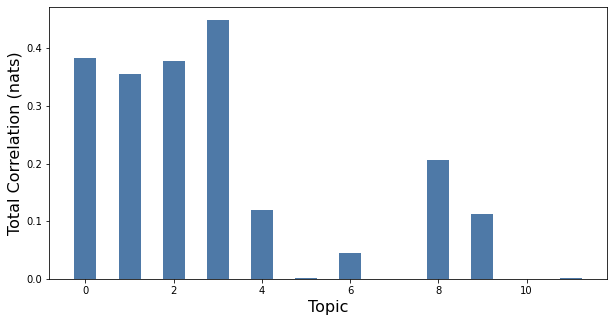

In [139]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [130]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range (20)]).astype(float)
topic_df.index = em_df.index
df = pd.concat([em_df, topic_df], axis=1)

In [ ]:
df.to_csv('/Users/chenjianyu/Desktop/Corex Topic Modelling/em_valuable_corex_topics.csv')

In [ ]:
topics_dict = {}

for i in range(20):
    topics_dict[f'topic{i}'] = {}
    topic = df[df[f'topic_{i+1}'] == 1.0]
    pos_count = df_topic0[df_topic0['Vader_compound_score'] >= 0.1]
    neg_count = df_topic0[df_topic0['Vader_compound_score'] <= -0.01]
    emotions_count = list(df_topic0['Emotions'].value_counts())

    topics_dict[f'topic{i}']['positive'] = len(pos_count)
    topics_dict[f'topic{i}']['negative'] = len(neg_count)
    topics_dict[f'topic{i}']['emotions'] = {
        'anger': emotions_count[0],
        'fear': emotions_count[1],
        'joy': emotions_count[2],
        'neutral': emotions_count[3],
        'sadness': emotions_count[4]
        }

topics_dict['anchors'] = anchors
topics_dict['top_words'] = top_words
    
pickle.dump(topics_dict, open('em_topic_counts.sav', 'wb'))
# x = pickle.load(open('tracetogether_topic_counts.sav', 'rb'))

# Tracetogether

In [57]:
em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/tracetogether_valuable_opinions.csv')
# em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/tracetogether_valuable_sentiments.csv')
em_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
em_df['Topic'] = 'Tracetogether'
len(em_df)

16827

In [58]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
# circuit_breaker_comments = cb_df[cb_df['Topic'] == 'Circuit Breaker']
# economic_measures_comments = cb_df[cb_df['Topic'] == 'Economic Measures']
# foreign_worker_comments = cb_df[cb_df['Topic'] == 'Foreign Worker']
# mask_comments = cb_df[cb_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
# social_distancing_comments = cb_df[cb_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
# vaccination_comments = cb_df[cb_df['Topic'] == 'Vaccination']
comments = [tracetogether_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in em_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

In [59]:
df_final['Relevance score'].describe()

count    16827.000000
mean        65.603680
std         93.189215
min          1.973119
25%         20.500271
50%         36.848291
75%         56.271756
max        408.447008
Name: Relevance score, dtype: float64

In [60]:
em_df = df_final[df_final['Relevance score'] <= 20]
len(em_df)

3893

In [61]:
eng_words = words.words()
comments = []
i = 0
for row in em_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

em_df['Comments'] = comments

<ipython-input-61-1f63f3ad2eb9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df['Comments'] = comments


In [62]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.5)
vectorizer = vectorizer.fit(em_df['Comments'])
tfidf = vectorizer.transform(em_df['Comments'])
vocab = vectorizer.get_feature_names()
len(vocab)

32708

In [64]:
anchors = [
    ['location', 'device', 'proximity', 'safe entry', 'movement', 'contact tracing', 'surveillance', 'track'], 
    ['privacy', 'investigation', 'crimes', 'transparent', 'police', 'data', 'criminal', 'law', 'open source'],
    ['slippery slope', 'government', 'policy', 'politician', 'minister', 'decision', 'trust'],
    ['cases', 'positive', 'negative', 'infected', 'symptoms',  'tested' , 'transmission', 'asymptomatic']
]
anchors = [
    [a for a in topic if a in vocab] for topic in anchors
]

model = ct.Corex(n_hidden = 20, seed = 8)
model = model.fit(tfidf, words = vocab, anchors = anchors, anchor_strength=7)

In [65]:
model.get_topics(topic=0, n_words=10)

[('device', 0.11594474493410467, 1.0),
 ('location', 0.09767742820254108, 1.0),
 ('track', 0.08454739468918834, 1.0),
 ('proximity', 0.05278743858743367, 1.0),
 ('movement', 0.022883263321449052, 1.0),
 ('safe entry', 0.016884191503488473, 1.0),
 ('location data', 0.004585695540621503, 1.0),
 ('proximity data', 0.0037688039653313407, 1.0),
 ('close proximity', 0.002636271283548421, 1.0),
 ('tracing device', 0.0021097923676690385, 1.0)]

In [92]:
top_words = {}

for i, topic_ngrams in enumerate(model.get_topics()):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    top_words[f'topic{i}'] = topic_ngrams
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    print()

Topic #1: device, location, track, proximity, movement, safe entry, location data, proximity data, close proximity, tracing device

Topic #2: police, criminal, data, investigation, law, open source, data used, data data, data criminal, used

Topic #3: trust, minister, politician, decision, government, trust government, trust people, public trust, minister said, policy

Topic #4: infected, positive, transmission, tested, asymptomatic, negative, infected person, contact infected, infected people, test positive

Topic #5: said scanning, scanning contact, similar higher, higher death, voice instead, instead sitting, kind person, sitting wait, know starter, try making

Topic #6: token code, problem ben, ben, ben people, latest, news vaccine, lately news, past history, history withdrawal, outbreak source

Topic #7: point world, mean check, act violence, independence, independence act, check point

Topic #8: furthermore, enforcement just, just doing, occasionally enforcement, freely commit, f

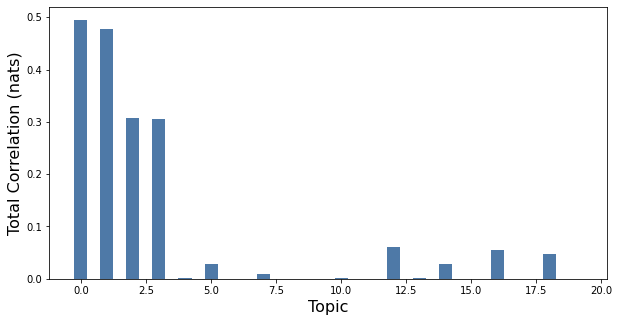

In [67]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [68]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range (20)]).astype(float)
topic_df.index = em_df.index
df = pd.concat([em_df, topic_df], axis=1)
df.head()

,Sentences,Comment Datetime,Textblob_polarity_score,Textblob_subjectivity_score,Vader_neg_score,Vader_neu_score,Vader_pos_score,Vader_compound_score,Emotions,Topic,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,Because TT takes a lot of battery and super la...,3/6/21,0.277778,0.430556,0.000,0.736,0.264,0.7783,joy,Tracetogether,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,"Peasantboy wrote: Recently, a lot of governmen...",3/6/21,0.000000,0.250000,0.000,1.000,0.000,0.0000,anger,Tracetogether,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
10,Waiting to go Parliament to make that law If t...,3/6/21,0.025000,0.458333,0.218,0.782,0.000,-0.7713,anger,Tracetogether,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
16,SG is the easiest place to roll out such thing...,3/6/21,-0.150000,0.541667,0.168,0.671,0.161,-0.0754,anger,Tracetogether,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
18,"Similar in the security industries, keep addin...",3/7/21,0.000000,0.325000,0.000,0.796,0.204,0.5994,fear,Tracetogether,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [86]:
df.to_csv('/Users/chenjianyu/Desktop/Corex Topic Modelling/tt_valuable_corex_topics.csv')

In [93]:
topics_dict = {}

for i in range(20):
    topics_dict[f'topic{i}'] = {}
    topic = df[df[f'topic_{i+1}'] == 1.0]
    pos_count = df_topic0[df_topic0['Vader_compound_score'] >= 0.1]
    neg_count = df_topic0[df_topic0['Vader_compound_score'] <= -0.01]
    emotions_count = list(df_topic0['Emotions'].value_counts())

    topics_dict[f'topic{i}']['positive'] = len(pos_count)
    topics_dict[f'topic{i}']['negative'] = len(neg_count)
    topics_dict[f'topic{i}']['emotions'] = {
        'anger': emotions_count[0],
        'fear': emotions_count[1],
        'joy': emotions_count[2],
        'neutral': emotions_count[3],
        'sadness': emotions_count[4]
        }

topics_dict['anchors'] = anchors
topics_dict['top_words'] = top_words
    
pickle.dump(topics_dict, open('tracetogether_topic_counts.sav', 'wb'))
# x = pickle.load(open('tracetogether_topic_counts.sav', 'rb'))

# Mask

In [140]:
em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/tracetogether_valuable_opinions.csv')
# em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/mask_valuable_sentiments.csv')
em_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
em_df['Topic'] = 'Mask'
len(em_df)

6038

In [141]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
# circuit_breaker_comments = cb_df[cb_df['Topic'] == 'Circuit Breaker']
# economic_measures_comments = cb_df[cb_df['Topic'] == 'Economic Measures']
# foreign_worker_comments = cb_df[cb_df['Topic'] == 'Foreign Worker']
mask_comments = em_df[em_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
# social_distancing_comments = cb_df[cb_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
# tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
# vaccination_comments = cb_df[cb_df['Topic'] == 'Vaccination']
comments = [mask_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in em_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

In [142]:
df_final['Relevance score'].describe()

count    6038.000000
mean       60.681229
std        89.481632
min         2.905036
25%        18.414744
50%        36.131131
75%        56.271756
max       408.447008
Name: Relevance score, dtype: float64

In [143]:
em_df = df_final[df_final['Relevance score'] <= 20]
len(em_df)

1569

In [144]:
eng_words = words.words()
comments = []
i = 0
for row in em_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

em_df['Comments'] = comments

<ipython-input-144-1f63f3ad2eb9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df['Comments'] = comments


In [145]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.5)
vectorizer = vectorizer.fit(em_df['Comments'])
tfidf = vectorizer.transform(em_df['Comments'])
vocab = vectorizer.get_feature_names()
len(vocab)

15394

In [146]:
anchors = [
    ['reusable', 'wash', 'disposable mask', 'collect', 'free', 'distribution', 'distribute', 'give', 'squeezing', 'washable'],
    ['cough', 'sneeze', 'no mask', 'hygiene', 'flu', 'sick', 'wear mask', 'prevent', 'exposure'],
    ['shortage', 'replenish', 'mask supply', 'manufacture', 'export mask', 'import mask', 'insufficient','frontline worker','sell'],
    ['exercise', 'running', 'jogging', 'smoking', 'eating', 'drinking', 'unmask'], 
    ['fines', 'comply', 'mandatory', 'socially responsible'],
    ['cases', 'control', 'positive', 'negative', 'test', 'asymptomatic', 'community', 'transmission', 'protection', 'critical']
]
anchors = [
    [a for a in topic if a in vocab] for topic in anchors
]

model = ct.Corex(n_hidden = 20, seed = 8)
model = model.fit(tfidf, words = vocab, anchors = anchors, anchor_strength=7)
# model.get_topics(topic=0, n_words=10)

In [147]:
for i, topic_ngrams in enumerate(model.get_topics()):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    print()

Topic #1: free, collect, sheep, people free, convenience, shepherd, clothes, final, given time, respect policy

Topic #2: sick, exposure, flu, fake news, fake, news, hygiene, coast, east coast, exposure notification

Topic #3: sell, insufficient, shortage, quarter, quarter population, winning, mad, gain access, access house, better record

Topic #4: running, exercise, interact, valuable, distance, school, whereabouts, company, mass testing, foreground

Topic #5: mandatory, comply, memory, know use, mandatory people, scanner, nowadays, police need, device location, location device

Topic #6: control, positive, test, protection, transmission, asymptomatic, covid positive, able track, control data, computer

Topic #7: scene, likely closet, closet opportunistic, closet, opportunistic, arms, vice, arms likely, opportunistic vice, think arms

Topic #8: addition, decided good, risk analysis, thing release, addition risk, addition shop, sarcasm, sarcasm people

Topic #9: murder course, need le

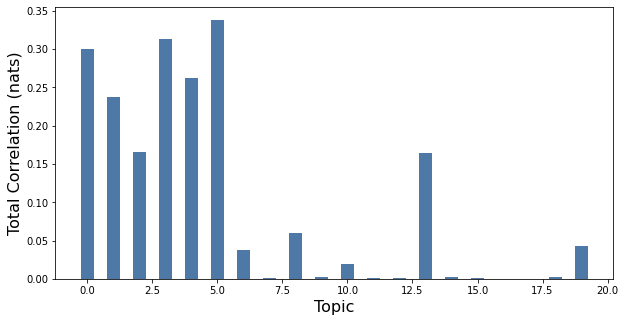

In [148]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [44]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range (20)]).astype(float)
topic_df.index = em_df.index
df = pd.concat([em_df, topic_df], axis=1)
df.head()

,Sentences,Comment Datetime,Textblob_polarity_score,Textblob_subjectivity_score,Vader_neg_score,Vader_neu_score,Vader_pos_score,Vader_compound_score,Emotions,Topic,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
3,"FireEmblem wrote: Got myself the XL size, haha...",3/9/21,0.100000,0.200000,0.000,0.695,0.305,0.7543,joy,Mask,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,The mask below portion bigger and also extend ...,3/9/21,0.105769,0.342308,0.057,0.905,0.038,-0.2247,fear,Mask,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,I am wearing high grade surgical mask which is...,3/9/21,0.072000,0.368000,0.000,0.919,0.081,0.4404,neutral,Mask,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Loosen the elastic tension on the ear loop... ...,3/9/21,-0.200000,0.100000,0.078,0.922,0.000,-0.3182,anger,Mask,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,"Also for mask in the current market, they are ...",3/9/21,0.056944,0.404167,0.155,0.845,0.000,-0.5801,anger,Mask,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df.to_csv('/Users/chenjianyu/Desktop/Corex Topic Modelling/mask_valuable_corex_topics.csv')

In [ ]:
topics_dict = {}

for i in range(20):
    topics_dict[f'topic{i}'] = {}
    topic = df[df[f'topic_{i+1}'] == 1.0]
    pos_count = df_topic0[df_topic0['Vader_compound_score'] >= 0.1]
    neg_count = df_topic0[df_topic0['Vader_compound_score'] <= -0.01]
    emotions_count = list(df_topic0['Emotions'].value_counts())

    topics_dict[f'topic{i}']['positive'] = len(pos_count)
    topics_dict[f'topic{i}']['negative'] = len(neg_count)
    topics_dict[f'topic{i}']['emotions'] = {
        'anger': emotions_count[0],
        'fear': emotions_count[1],
        'joy': emotions_count[2],
        'neutral': emotions_count[3],
        'sadness': emotions_count[4]
        }

topics_dict['anchors'] = anchors
topics_dict['top_words'] = top_words
    
pickle.dump(topics_dict, open('mask_topic_counts.sav', 'wb'))
# x = pickle.load(open('tracetogether_topic_counts.sav', 'rb'))

# Social Distancing

In [156]:
em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/social distancing_valuable_opinions.csv')
em_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
em_df['Topic'] = 'Social Distancing'
len(em_df)

2025

In [157]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
# circuit_breaker_comments = cb_df[cb_df['Topic'] == 'Circuit Breaker']
# economic_measures_comments = cb_df[cb_df['Topic'] == 'Economic Measures']
# foreign_worker_comments = cb_df[cb_df['Topic'] == 'Foreign Worker']
# mask_comments = cb_df[cb_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
social_distancing_comments = em_df[em_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
# tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
# vaccination_comments = cb_df[cb_df['Topic'] == 'Vaccination']
comments = [social_distancing_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in em_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

In [158]:
df_final['Relevance score'].describe()

count    2025.000000
mean       58.870352
std        86.054803
min         1.870969
25%        18.769575
50%        31.288213
75%        56.271756
max       408.447008
Name: Relevance score, dtype: float64

In [159]:
em_df = df_final[df_final['Relevance score'] <= 20]
len(em_df)

519

In [160]:
eng_words = words.words()
comments = []
i = 0
for row in em_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

em_df['Comments'] = comments

<ipython-input-160-1f63f3ad2eb9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df['Comments'] = comments


In [161]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.5)
vectorizer = vectorizer.fit(em_df['Comments'])
tfidf = vectorizer.transform(em_df['Comments'])
vocab = vectorizer.get_feature_names()
len(vocab)

6815

In [162]:
anchors = [
    ['chinese new year', 'cny', 'household', 'visitors', 'neighbour', 'visiting', 'chinatown', 'home', 'maximum', 'mask'], 
    ['ambassador', 'officer', 'fined', 'fines', 'offence', 'enforcement', 'enforce', 'illegal'],
    ['diners', 'apart', 'intermingling', 'gathering', 'group', 'groups', 'dine', 'family', 'restaurant'],
    ['transport', 'bus', 'train', 'distance', 'distancing', 'crowd', 'mrt', 'safe distancing', 'social distancing', 'standing close'],
    ['safe management', 'control', 'risk', 'limit', 'reduce exposure', 'restriction', 'infected']
]
anchors = [
    [a for a in topic if a in vocab] for topic in anchors
]

model = ct.Corex(n_hidden = 20, seed = 8)
model = model.fit(tfidf, words = vocab, anchors = anchors, anchor_strength=7)
# model.get_topics(topic=0, n_words=10)

In [163]:
top_words = {}

for i, topic_ngrams in enumerate(model.get_topics()):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    top_words[f'topic{i}'] = topic_ngrams
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    print()

Topic #1: home, mask, household, visiting, maximum, stay home, work home, wearing mask, working home, work

Topic #2: enforcement, enforce, ambassador, officer, safe ambassador, liang, clean, clean safe, enforcement clean, easy

Topic #3: apart, restaurant, saw, foot, foot locker, locker, career, traditional, transmission, reach

Topic #4: bus, crowd, distance, train, vast, vast majority, reduce crowd, majority, huge crowd, country leadership

Topic #5: safe management, risk, control, limit, management, reduce exposure, tuition, high, restriction, latest news

Topic #6: racist, race, certain race, people certain, certain, smart right, mobility smart, mobility, bait, bait racist

Topic #7: day frequency, frequency peak, imposing way, way comply, imposing, start imposing, think start, frequency

Topic #8: lotus, lotus sutra, sutra, interchange hawker, interchange, safe interchange, teaching, enhanced offer, offer, offer delivery

Topic #9: 

Topic #10: literally bother, bother basically,

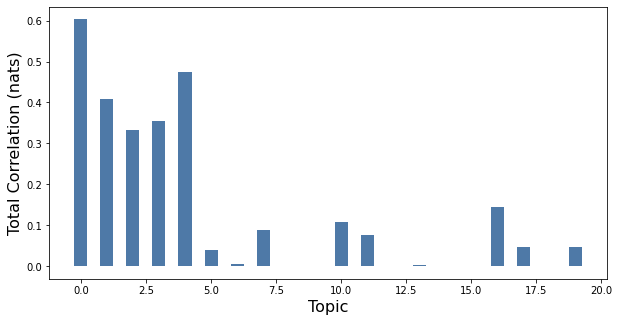

In [164]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [165]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range (20)]).astype(float)
topic_df.index = em_df.index
df = pd.concat([em_df, topic_df], axis=1)
df.head()

,Sentences,Comment Datetime,Textblob_polarity_score,Textblob_subjectivity_score,Vader_neg_score,Vader_neu_score,Vader_pos_score,Vader_compound_score,Emotions,Topic,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,Another smart aleck \x93People should limit th...,21/2/21,0.138095,0.614286,0.000,0.909,0.091,0.4019,joy,Social Distancing,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Additional measures currently in place include...,20/2/21,0.187500,0.700000,0.000,0.920,0.080,0.2732,neutral,Social Distancing,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,While no major incident has been reported and ...,20/2/21,0.006250,0.666667,0.091,0.909,0.000,-0.2960,fear,Social Distancing,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,WhiteAnt wrote: If no such thing as visit 2 ho...,16/2/21,-0.250000,0.750000,0.120,0.836,0.044,-0.4754,anger,Social Distancing,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14,Multi-Ministry Task Force (MTF) co-chair Lawre...,23/1/21,0.284848,0.643939,0.000,1.000,0.000,0.0000,anger,Social Distancing,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.to_csv('/Users/chenjianyu/Desktop/Corex Topic Modelling/sd_valuable_corex_topics.csv')

In [ ]:
topics_dict = {}

for i in range(20):
    topics_dict[f'topic{i}'] = {}
    topic = df[df[f'topic_{i+1}'] == 1.0]
    pos_count = df_topic0[df_topic0['Vader_compound_score'] >= 0.1]
    neg_count = df_topic0[df_topic0['Vader_compound_score'] <= -0.01]
    emotions_count = list(df_topic0['Emotions'].value_counts())

    topics_dict[f'topic{i}']['positive'] = len(pos_count)
    topics_dict[f'topic{i}']['negative'] = len(neg_count)
    topics_dict[f'topic{i}']['emotions'] = {
        'anger': emotions_count[0],
        'fear': emotions_count[1],
        'joy': emotions_count[2],
        'neutral': emotions_count[3],
        'sadness': emotions_count[4]
        }

topics_dict['anchors'] = anchors
topics_dict['top_words'] = top_words
    
pickle.dump(topics_dict, open('sd_topic_counts.sav', 'wb'))
# x = pickle.load(open('tracetogether_topic_counts.sav', 'rb'))

# Vaccination

In [166]:
em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/vaccination_valuable_opinions.csv')
em_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
em_df['Topic'] = 'Vaccination'
len(em_df)

3282

In [168]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
# circuit_breaker_comments = cb_df[cb_df['Topic'] == 'Circuit Breaker']
# economic_measures_comments = cb_df[cb_df['Topic'] == 'Economic Measures']
# foreign_worker_comments = cb_df[cb_df['Topic'] == 'Foreign Worker']
# mask_comments = cb_df[cb_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
# social_distancing_comments = cb_df[cb_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
# tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
vaccination_comments = em_df[em_df['Topic'] == 'Vaccination']
comments = [vaccination_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in em_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

In [169]:
df_final['Relevance score'].describe()

count    3282.000000
mean       57.902616
std        85.131756
min         2.762035
25%        18.438717
50%        36.131131
75%        56.271756
max       408.447008
Name: Relevance score, dtype: float64

In [170]:
em_df = df_final[df_final['Relevance score'] <= 20]
len(em_df)

854

In [171]:
eng_words = words.words()
comments = []
i = 0
for row in em_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

em_df['Comments'] = comments

<ipython-input-171-1f63f3ad2eb9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df['Comments'] = comments


In [172]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.5)
vectorizer = vectorizer.fit(em_df['Comments'])
tfidf = vectorizer.transform(em_df['Comments'])
vocab = vectorizer.get_feature_names()
len(vocab)

9401

In [173]:
anchors = [
    ['death', 'died', 'side effect', 'reaction', 'allergy', 'effects', 'fever', 'fatigue', 'risk', 'allergic', 'condition'], 
    ['essential workers', 'elderly', 'seniors', 'healthcare workers'], 
    ['approve', 'approval', 'arrival', 'shipment', 'test', 'trial', 'effectiveness'], 
    ['false news', 'fake news'], 
    ['Voluntary','vaccination centre', 'compulsory'], 
    ['vaccine passport', 'travel']
]
anchors = [
    [a for a in topic if a in vocab] for topic in anchors
]

model = ct.Corex(n_hidden = 20, seed = 8)
model = model.fit(tfidf, words = vocab, anchors = anchors, anchor_strength=7)
model.get_topics(topic=0, n_words=10)

In [174]:
top_words = {}

for i, topic_ngrams in enumerate(model.get_topics()):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    top_words[f'topic{i}'] = topic_ngrams
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    print()

Topic #1: effects, death, allergic, reaction, fever, health minister, minister said, dose, minister, hong health

Topic #2: elderly, diabetes, cocktail antibody, unit, injured, health like, related vaccination, stake, ward, cocktail

Topic #3: trial, shipment, arrival, phase trial, trial data, lancet, people vaccination, active, active surveillance, surveillance status

Topic #4: fake news, chicken, approach, bell palsy, palsy, bell, construction, chicken rice, met, rice

Topic #5: compulsory, way, healthy, spike, office, anna peter, anna, effective safe, effective vaccination, vaccination infected

Topic #6: code, bay, telegram, code contribute, source code, road, contribute, thats waiting, tink vaccine, waiting tink

Topic #7: key word, comment approval, approval key, word, end unforeseen, unforeseen vaccine, unforeseen, comment, wrote comment

Topic #8: saying saying, mean saying, contrary vaccine, saying contrary, vaccine doing, doing risk, vaccine ask, exemption, ask exemption

To

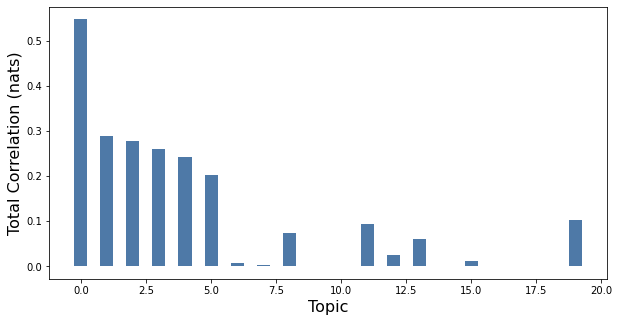

In [175]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [ ]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range (20)]).astype(float)
topic_df.index = em_df.index
df = pd.concat([em_df, topic_df], axis=1)
df.head()

In [ ]:
df.to_csv('/Users/chenjianyu/Desktop/Corex Topic Modelling/vaccination_valuable_corex_topics.csv')

In [ ]:
topics_dict = {}

for i in range(20):
    topics_dict[f'topic{i}'] = {}
    topic = df[df[f'topic_{i+1}'] == 1.0]
    pos_count = df_topic0[df_topic0['Vader_compound_score'] >= 0.1]
    neg_count = df_topic0[df_topic0['Vader_compound_score'] <= -0.01]
    emotions_count = list(df_topic0['Emotions'].value_counts())

    topics_dict[f'topic{i}']['positive'] = len(pos_count)
    topics_dict[f'topic{i}']['negative'] = len(neg_count)
    topics_dict[f'topic{i}']['emotions'] = {
        'anger': emotions_count[0],
        'fear': emotions_count[1],
        'joy': emotions_count[2],
        'neutral': emotions_count[3],
        'sadness': emotions_count[4]
        }

topics_dict['anchors'] = anchors
topics_dict['top_words'] = top_words
    
pickle.dump(topics_dict, open('vaccination_topic_counts.sav', 'wb'))
# x = pickle.load(open('tracetogether_topic_counts.sav', 'rb'))

# Foreign Worker

In [176]:
em_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/foreign worker_valuable_opinions.csv')
em_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
em_df['Topic'] = 'Foreign Worker'
len(em_df)

3132

In [177]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
# circuit_breaker_comments = cb_df[cb_df['Topic'] == 'Circuit Breaker']
# economic_measures_comments = cb_df[cb_df['Topic'] == 'Economic Measures']
foreign_worker_comments = em_df[em_df['Topic'] == 'Foreign Worker']
# mask_comments = cb_df[cb_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
# social_distancing_comments = cb_df[cb_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
# tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
# vaccination_comments = cb_df[cb_df['Topic'] == 'Vaccination']
comments = [foreign_worker_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in em_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

In [178]:
df_final['Relevance score'].describe()

count    3132.000000
mean       54.607031
std        80.675476
min         2.318348
25%        16.878383
50%        26.835207
75%        56.271756
max       408.447008
Name: Relevance score, dtype: float64

In [179]:
em_df = df_final[df_final['Relevance score'] <= 20]
len(em_df)

833

In [180]:
eng_words = words.words()
comments = []
i = 0
for row in em_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

em_df['Comments'] = comments

<ipython-input-180-1f63f3ad2eb9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df['Comments'] = comments


In [182]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.5)
vectorizer = vectorizer.fit(em_df['Comments'])
tfidf = vectorizer.transform(em_df['Comments'])
vocab = vectorizer.get_feature_names()
len(vocab)

9760

In [183]:
anchors = [
    ['dormitories', 'crammed', 'density', 'violate regulation', 'dorm', 'distance', 'crowded', 'poor condition', 'living condition'], 
    ['isolate', 'quarantine', 'identify', 'potential', 'infected', 'carrier'], 
    ['swab test',  'covid testing',  'testing', 'risk', 're-infection', 'cases', 'positive', 'negative', 'asymptomatic', 
    'frontline workers', 'healthcare workers'], 
    ['spread', 'huge', 'cluster', 'capacity', 'cope', 'rapid'], 
    ['employers', 'responsibility', 'bear', 'bill', 'tax payers', 'fine']
]
anchors = [
    [a for a in topic if a in vocab] for topic in anchors
]

model = ct.Corex(n_hidden = 20, seed = 8)
model = model.fit(tfidf, words = vocab, anchors = anchors, anchor_strength=7)
# model.get_topics(topic=0, n_words=10)

In [184]:
top_words = {}

for i, topic_ngrams in enumerate(model.get_topics()):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    top_words[f'topic{i}'] = topic_ngrams
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
    print()

Topic #1: dorm, crowded, distance, dorm spreading, migrant dorm, especially migrant, thank covid, situation especially, dorm bad, spreading

Topic #2: infected, quarantine, potential, identify, isolate, carrier, people infected, closure, mean infected, calling

Topic #3: testing, asymptomatic, covid testing, swab test, asymptomatic mild, flip, ignorance, ministry health, employment, spore

Topic #4: spread, huge, cluster, cope, rapid, community spread, opposition, labour, spread covid, staff food

Topic #5: responsibility, bear, various, supermarket, road, cried, parliament, source code, code contribute, code

Topic #6: number migrant, think high

Topic #7: 

Topic #8: know look, construction know, look money

Topic #9: fact, fact people, far likely, likely fact, think far, migrant tend, tend young, young fact, working overtime, just working

Topic #10: 

Topic #11: grim, grim fresh, fresh mind, sure contact, contact home, fresh, mind trust, trust power, mind remember, remember weekend

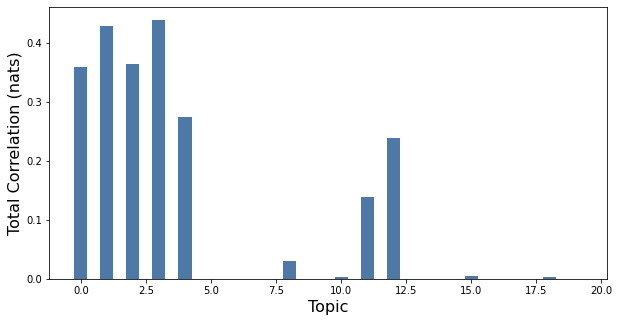

In [185]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [ ]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range (20)]).astype(float)
topic_df.index = em_df.index
df = pd.concat([em_df, topic_df], axis=1)
df.head()

In [ ]:
df.to_csv('/Users/chenjianyu/Desktop/Corex Topic Modelling/fw_valuable_corex_topics.csv')

In [ ]:
topics_dict = {}

for i in range(20):
    topics_dict[f'topic{i}'] = {}
    topic = df[df[f'topic_{i+1}'] == 1.0]
    pos_count = df_topic0[df_topic0['Vader_compound_score'] >= 0.1]
    neg_count = df_topic0[df_topic0['Vader_compound_score'] <= -0.01]
    emotions_count = list(df_topic0['Emotions'].value_counts())

    topics_dict[f'topic{i}']['positive'] = len(pos_count)
    topics_dict[f'topic{i}']['negative'] = len(neg_count)
    topics_dict[f'topic{i}']['emotions'] = {
        'anger': emotions_count[0],
        'fear': emotions_count[1],
        'joy': emotions_count[2],
        'neutral': emotions_count[3],
        'sadness': emotions_count[4]
        }

topics_dict['anchors'] = anchors
topics_dict['top_words'] = top_words
    
pickle.dump(topics_dict, open('tracetogether_topic_counts.sav', 'wb'))
# x = pickle.load(open('tracetogether_topic_counts.sav', 'rb'))